In [1]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve2d
from scipy.ndimage import rotate
%matplotlib inline

from plotting_helper import * 


figures_path = 'figures/'

(5000, 10, 10)


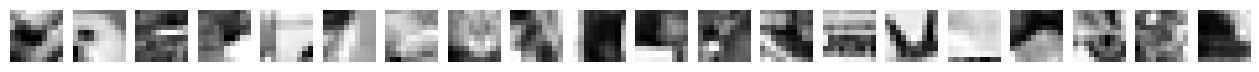

In [2]:
images = np.load('cifar_patches_10x10_zca.npz')['images']
images = images - images.mean()
# plot 10 images
figure(figsize=(16, 10))
for i in range(20):
    subplot(1, 20, i+1)
    imshow(images[i], cmap=plt.cm.gray)#, vmin=-1, vmax=1)
    axis('off')


images[0].min(), images[0].max()

print(images.shape)


In [3]:
start_scope()

seed(42)


# parameters
##########################################
g = 1/15
tau_s = 15 * ms
tau_m = 10 * ms 
tau_p = 7 * ms
A_d = 8.e-5
A_p = 1.5e-4
theta_m = -70 * mV
theta_p = -68 * mV 
eta = 1
min_w = 0.01
max_w = 1 
tau_w = 1 * ms

# VDP equations
##########################################

syn_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = clip(eta * (A_p  * (vp - theta_p)/mV*int((vp - theta_p)/mV > 0 ) - A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)) * s /tau_w * dt, (min_w - w), (max_w-w))/dt : 1 (clock-driven)

'''


# Neurons with Ornstien-Uhlenbeck noise
##########################################

vrest = -70 * mV
tau_syn_e = 2 * ms 
tau_syn_i = 2 * ms


# reversal potentials
E_exc = 0 * mV 
E_inh = -80 * mV

neuron_eqs = '''
    dv/dt = (vrest-v)/tau - I_syn_e * (v-E_exc)/tau - I_syn_i * (v-E_inh)/tau - ref_amp * Iref/tau + n_sigma*xi*tau**-0.5 : volt (unless refractory)
    dI_syn_e/dt = -I_syn_e/tau_syn_e : 1
    dI_syn_i/dt = -I_syn_i/tau_syn_i : 1
    dvt/dt = (-60*mV-vt)/(30*ms) : volt
    dIref/dt = -Iref/(500*ms) : volt
    n_sigma : volt
    tau : second
    ref_amp : 1
'''

reset = '''
v = -75*mV
vt += 0.0*mV
Iref += 0.0*mV
'''

# excitatory neurons
N_exc = 200
N_inh = 50
N_exc_in = N_exc

GE = NeuronGroup(N_exc, neuron_eqs, reset=reset, threshold='v>vt',
                refractory=0*ms, method='euler')
GE.n_sigma = 3 * mV
GE.v = vrest
GE.vt = -69*mV
GE.tau = 5*ms
GE.ref_amp = 0

# inhibitory neurons
GI = NeuronGroup(N_inh, neuron_eqs, reset=reset, threshold='v>vt',
                refractory=0*ms, method='euler')
GI.n_sigma = 0 * mV
GI.v = vrest
GI.vt = -69*mV
GI.tau = 2*ms
GI.ref_amp = 0

# Inputs
##########################################

N_stim = 10

stim_eqs = '''
            dI/dt = (-I + I_in - 2*I2) /(10*ms) : 1
            dI2/dt = (-I2 + I) /(40*ms) : 1
            dv/dt = (-v + I)/(5*ms)  : 1
            dtheta/dt = (0.2 - theta)/(10*ms) + n_sigma*xi*(10*ms)**-0.5 : 1
            I_in : 1  # one stimulus per neuron
            n_sigma : 1 
            '''

IG1 = NeuronGroup(N_stim*N_stim, stim_eqs,
                        threshold = 'v > theta',
                        refractory = 5*ms,
                        reset = 'v=0')

IG2 = NeuronGroup(N_stim*N_stim, stim_eqs,
                        threshold = 'v > theta',
                        refractory = 5*ms,
                        reset = 'v=0')

n_stim = 1000
length_stim = 50
presentation = np.arange(n_stim)

@network_operation(dt = n_stim * length_stim *ms)
def presentation_order(t): 
    presentation = np.random.permutation(n_stim)

@network_operation(dt=length_stim*ms)
def stripes_bars(t):
    pattern = images[presentation[int(t/(length_stim*ms))%n_stim]]
    IG1.I_in = pattern.flatten()*1
    IG1.I = 0
    IG1.I2 = 0
    IG2.I_in = -pattern.flatten()*1
    IG2.I = 0
    IG2.I2 = 0

IG1.n_sigma = 0
IG2.n_sigma = 0



# Synapses
##########################################

# conductances
sf = .1
IG_g = 10/np.sqrt(2*N_stim)*sf
IG_I_g = 10/np.sqrt(N_stim*N_stim)*sf*0
EE_g = 10/np.sqrt(4)*sf*0.1
IE_g = 10/N_exc*sf
EI_g = 10/np.sqrt(N_inh)*sf*3
II_g = 10/np.sqrt(4)*sf

#set vm and vp, should forget this.... 
S_EE = Synapses(GE, GE, syn_eq,
             on_pre='''
             I_syn_e += w * EE_g
             s += g''', 
             method='euler')
S_EE.connect(j='(i + k) % N_exc for k in range(-1, 1, 2)')
S_EE.connect(j='(i - k) % N_exc for k in range(-1, 1, 2)')
S_EE.connect(j='(i + k) % N_exc for k in range(-2, 2, 4)')
S_EE.connect(j='(i - k) % N_exc for k in range(-2, 2, 4)')
S_EE.vm  = vrest
S_EE.vp = vrest

S_IE = Synapses(GE, GI, syn_eq,
             on_pre='''
             I_syn_e += w * IE_g
             s += g''', method='euler')
S_IE.connect(p=1)
S_IE.vm  = vrest
S_IE.vp = vrest

S_II = Synapses(GI, GI, syn_eq,
             on_pre='''
             I_syn_i += w * II_g
             s += g''', method='euler')
S_II.connect(j='(i + k) % N_inh for k in range(-1, 1, 2)')
S_II.connect(j='(i - k) % N_inh for k in range(-1, 1, 2)')
S_II.connect(j='(i + k) % N_inh for k in range(-2, 2, 4)')
S_II.connect(j='(i - k) % N_inh for k in range(-2, 2, 4)')
S_II.vm  = vrest
S_II.vp = vrest

S_EI = Synapses(GI, GE, syn_eq,
             on_pre='''
             I_syn_i += w * EI_g
             s += g''', method='euler')
S_EI.connect(p=1)
S_EI.vm  = vrest
S_EI.vp = vrest

S_IG1 = Synapses(IG1, GE[:N_exc_in], syn_eq,
             on_pre='''
             I_syn_e += w * IG_g
             s += g''', method='euler')
S_IG1.connect(p=1)
S_IG1.vm  = vrest
S_IG1.vp = vrest

S_IG2 = Synapses(IG2, GE[:N_exc_in], syn_eq,
             on_pre='''
             I_syn_e += w * IG_g
             s += g''', method='euler')
S_IG2.connect(p=1)
S_IG2.vm  = vrest
S_IG2.vp = vrest

S_IG1.w = '.7*rand()+.2'
S_IG2.w = '.7*rand()+.2'
S_EE.w = '.7*rand()+.2'
S_IE.w = '.7*rand()+.2'
S_EI.w = '.7*rand()+.2'
S_II.w = '.7*rand()+.2'

S_IG1.w = 'rand()'
S_IG2.w = 'rand()'
S_EE.w = '.7*rand()'
S_IE.w = '.7*rand()'
S_EI.w = '.7*rand()'
S_II.w = '.7*rand()'

# Monitors
##########################################

rate_monitor_E = PopulationRateMonitor(GE)
rate_monitor_I = PopulationRateMonitor(GI)

spike_monitor_E = SpikeMonitor(GE)
spike_monitor_I = SpikeMonitor(GI)
spike_monitor_IG1 = SpikeMonitor(IG1)
spike_monitor_IG2 = SpikeMonitor(IG2)

    
recorded_cells = [5,13,24,26]

M_IG1 = StateMonitor(S_IG1, ['w'], record=S_IG1[:,recorded_cells], dt=10 * second)
M_IG2 = StateMonitor(S_IG2, ['w'], record=S_IG2[:,recorded_cells], dt=10 * second)



INFO:root:creating /tmp/brian_flag_test_n3qhj2x5/tmp
INFO:root:creating /tmp/brian_flag_test_n3qhj2x5/tmp/brian_flag_test_n3qhj2x5
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_n3qhj2x5/flag_test.cpp -o /tmp/brian_flag_test_n3qhj2x5/tmp/brian_flag_test_n3qhj2x5/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_guggqlxf/tmp
INFO:root:creating /tmp/brian_flag_test_guggqlxf/tmp/brian_flag_test_guggqlxf
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_guggqlxf/flag_test.cpp -o /tmp/brian_flag_test_guggqlxf/tmp/brian_flag_test_guggqlxf/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test_e90yf6ci/tmp
INFO:root:creating /tmp/brian_flag_test_e90yf6ci/tmp/brian_flag_test_e90yf6ci
INFO

INFO:root:g++ -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -pthread -shared -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -L/disk/scratch/prubisch/miniconda/envs/brian_env/lib -Wl,-rpath=/disk/scratch/prubisch/miniconda/envs/brian_env/lib -Wl,--no-as-needed -Wl,--sysroot=/ /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_02cc6a2956688461691f9718895154b1.o -L/disk/scratch/prubisch/miniconda/envs/brian_env/lib -Wl,--enable-new-dtags,-R/disk/scratch/prubisch/miniconda/envs/brian_env/lib -o /afs/inf.ed.ac.uk/user/s15/s1576881/.cython/brian_extensions/_cython_magic_02cc6a2956688461691f9718895154b1.cpython-38-x86_64-linux-gnu.so
WARNING    'i' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO:

In [4]:
#only run for the initial run

# plot voltage traces
# M_E_v = StateMonitor(GE, ['v'], record=range(5), dt=.1 * ms)
# M_I_v = StateMonitor(GI, ['v'], record=range(5), dt=.1 * ms)

# # warm up
# run(500*ms)

# figure(figsize=(12,4))
# subplot(211)
# plot(M_E_v.t/ms, M_E_v.v[0]/mV, 'r', label='E')
# # plot(M_E_v.t/ms, M_E_v.v[1]/mV, 'r')
# subplot(212)
# plot(M_I_v.t/ms, M_I_v.v[0]/mV, 'b', label='I')
# # plot(M_I_v.t/ms, M_I_v.v[1]/mV, 'b')
# del M_E_v
# del M_I_v

In [6]:
#run(10500 * second, report = 'text') #this is the total time needed 
restore(filename = '/disk/scratch/prubisch/brian_data/last_state_receptive_fields_network_meissner_bernard_proper_randomised')

#run(1000 * second, report = 'text') #last run 10000s

W_inp1 = np.full([N_stim**2, N_exc], np.nan)
W_inp1[S_IG1.i[:], S_IG1.j[:]] = S_IG1.w[:]

W_inp2 = np.full([N_stim**2, N_exc], np.nan)
W_inp2[S_IG2.i[:], S_IG2.j[:]] = S_IG2.w[:]

np.save('functional_sim_w/receptive_fields_W_mb.npy', [W_inp1,W_inp2])

#store(filename = '/disk/scratch/prubisch/brian_data/last_state_receptive_fields_network_meissner_bernard_proper_randomised')

In [13]:
#calculate receptive fields , compute statistics and filter the receptive fields for visualisation

#calculate receptive fields from input weights
all_rfs = np.zeros([N_exc, N_stim, N_stim])
for i in range(N_exc): 
    w1 = S_IG1.w[i::int(N_exc)].reshape((N_stim,N_stim))
    w2 = S_IG2.w[i::int(N_exc)].reshape((N_stim,N_stim))
    all_rfs[i] = w1 - w2



x = np.tile(np.arange(-5,6),(11,1)) #tiling of the space, also the size of the kernel
y = x.T 
sd = 3 #standard deviation of the gaussian
orientations = np.linspace(0,1,100)  #orientations of the filter, this is a ratio of x and y contribution in the sine function
rotations = [0,30,45,60,90,75,180]  #rotations of the images and rfs for testing against aliasing

#calculating the Gabor patches with teo different spatial frequencies and several orientations
kernel_dict_broad = np.zeros([orientations.shape[0],len(x), len(x)])
kernel_dict_fine = np.zeros([orientations.shape[0],len(x), len(x)])
for i in range(orientations.shape[0]): 
    kernel_dict_fine[-i-1] = np.exp(-(x*x+y*y)/(2*sd**2))*np.sin(((orientations[i])*y+(1-orientations[i])*x)/1)
    kernel_dict_broad[-i-1] = np.exp(-(x*x+y*y)/(2*sd**2))*np.sin(((orientations[i])*y+(1-orientations[i])*x)/10)

powers_neural_kernel_fine = np.zeros([len(rotations), orientations.shape[0],2])
powers_neural_kernel_broad = np.zeros([len(rotations), orientations.shape[0],2])
powers_per_kernel_fine = np.zeros([len(rotations), orientations.shape[0],2])
powers_per_kernel_broad = np.zeros([len(rotations), orientations.shape[0],2])


for r in range(len(rotations)): 
    for o in range(orientations.shape[0]):
        per_k_f = np.zeros(images.shape)
        per_k_b = np.zeros(images.shape)
        for im_ind in range(images.shape[0]): 
            conv = convolve2d(rotate(images[im_ind], rotations[r], reshape=False),kernel_dict_fine[o], mode = 'same')
            per_k_f[im_ind] = np.abs(conv) 
            conv = convolve2d(rotate(images[im_ind], rotations[r], reshape=False),kernel_dict_broad[o], mode = 'same')
            per_k_b[im_ind] = np.abs(conv)
        powers_per_kernel_fine[r,o,0] = np.mean(per_k_f)
        powers_per_kernel_fine[r,o,1] = np.std(per_k_f)
        powers_per_kernel_broad[r,o,0] = np.mean(per_k_b)
        powers_per_kernel_broad[r,o,1] = np.std(per_k_b)

        per_k_f = np.zeros(all_rfs.shape)
        per_k_b = np.zeros(all_rfs.shape)
        for im_ind in range(all_rfs.shape[0]): 
            conv = convolve2d(rotate(all_rfs[im_ind], rotations[r], reshape=False),kernel_dict_fine[o], mode = 'same')
            per_k_f[im_ind] = np.abs(conv)  #computes how active the filter is
            conv = convolve2d(rotate(all_rfs[im_ind], rotations[r], reshape=False),kernel_dict_broad[o], mode = 'same')
            per_k_b[im_ind] = np.abs(conv)
        powers_neural_kernel_fine[r,o,0] = np.mean(per_k_f)
        powers_neural_kernel_fine[r,o,1] = np.std(per_k_f)
        powers_neural_kernel_broad[r,o,0] = np.mean(per_k_b)
        powers_neural_kernel_broad[r,o,1] = np.std(per_k_b)
    

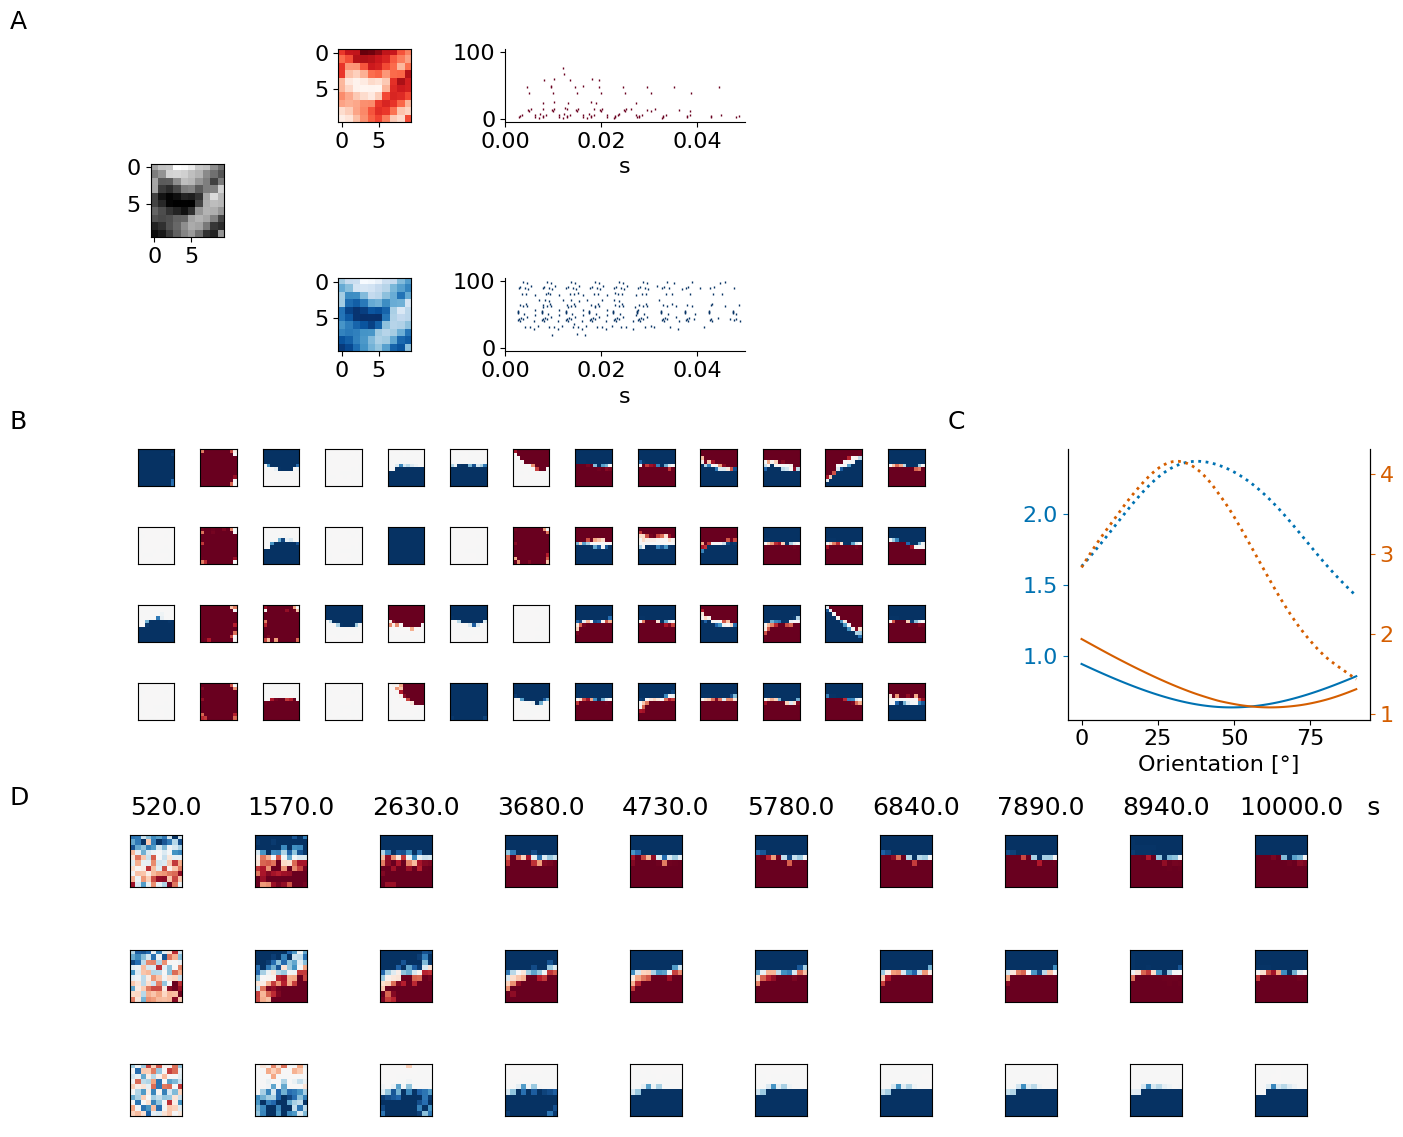

In [14]:
#continue to fix plotting here so it is acurate and shows the correct stuff

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

layout = '''
    AAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAA
    BBBBBBBBBBBBBBBCCCCC
    BBBBBBBBBBBBBBBCCCCC
    BBBBBBBBBBBBBBBCCCCC
    BBBBBBBBBBBBBBBCCCCC
    BBBBBBBBBBBBBBBCCCCC
    DDDDDDDDDDDDDDDDDDDD
    DDDDDDDDDDDDDDDDDDDD
    DDDDDDDDDDDDDDDDDDDD
    
    '''

fig = plt.figure(figsize=(16, 14))

height_ratios = [1,1,1,.2, 0.5,.5, .5,.5,0.3, 1,1, 1]
width_ratios = [0.2, 0.2, 0.2,0.2,0.2,.2, .2,.2,.2,.2,0.2, 0.2, 0.2,0.2,0.2,.2, .2,.2,.2,.2]


specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABCD', postfix='', offset_left=1.2)
for a in list('ABCD'):
    axes[a].set_axis_off()
    

#plot input specification

ax = fig.add_subplot(gs[1,0:2])
#plot one patch as it appears
images = np.load('cifar_patches_10x10_zca.npz')['images']
images = images - images.mean()
ax.imshow(images[0],cmap=plt.cm.gray)

ax = fig.add_subplot(gs[0,3:5])
#plot on copy
ax.imshow(images[0] * 1, cmap = plt.cm.Reds)
ax = fig.add_subplot(gs[0,6:10])
ax.plot(spike_monitor_IG1.t / second, spike_monitor_IG1.i, "|",color = '#69001fff', ms=2)
ax.set_xlim(0,0.05)
ax.set_xlabel('s')
clear_axes(ax)

#plot off copy
ax = fig.add_subplot(gs[2,3:5])
ax.imshow(-images[0] *1, cmap = plt.cm.Blues)
ax = fig.add_subplot(gs[2,6:10])
ax.plot(spike_monitor_IG2.t / second, spike_monitor_IG2.i, "|",color = '#063263ff', ms=2)
ax.set_xlim(0,0.05)
ax.set_xlabel('s')
clear_axes(ax)


#we filter the rfs to separate in monopolar rfs and true rfs with strong connection to both input populations
true_rfs = []
mono_rfs = []
for rf in range(all_rfs.shape[0]): 
    if np.any(all_rfs[rf] > 5e-1) and np.any(all_rfs[rf] < -5e-1): 
        true_rfs.append(all_rfs[rf])
    else: 
        mono_rfs.append(all_rfs[rf])

# # #plot the receptive fields
for j in range(13):
    for i  in range(4):
        ax = fig.add_subplot(gs[4+i,j])
        gp = np.full((N_stim,N_stim), np.nan)
        if j >= 7: 
            gp = true_rfs[(j-7)*4 + i]
        else: 
            gp = mono_rfs[(j)*4 + i]
        ax.imshow(gp, vmin=-1, vmax=1, cmap = 'RdBu_r', interpolation='none')
        ax.set_xticks(())
        ax.set_yticks(())
        
        
#plot receptive field statistics
ax = fig.add_subplot(gs[4:8, 15:20])
ax.plot(np.linspace(0,90,orientations.shape[0]), powers_per_kernel_broad[0,:,0], color = palette[0])
ax.plot(np.linspace(0,90,orientations.shape[0]), powers_per_kernel_fine[0,:,0], color = palette[0], linestyle = ':', linewidth = 2)
ax2 = ax.twinx()
ax2.plot(np.linspace(0,90,orientations.shape[0]), powers_neural_kernel_broad[0,:,0], color = palette[2])
ax2.plot(np.linspace(0,90,orientations.shape[0]), powers_neural_kernel_fine[0,:,0], color = palette[2], linestyle = ':', linewidth = 2)
ax2.tick_params(axis='y', colors=palette[2])
ax.tick_params(axis='y', colors=palette[0])
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.set_xlabel('Orientation [°]')
        
#plot receptive field development
n_plots = 20
    
recorded_cells = [5,13,24,26]
n_cells = len(recorded_cells)
time_points = np.linspace(0,M_IG1.w.shape[1]-1,n_plots, dtype = 'int')

onsets = np.zeros([20])+0
onsets[2:-1] = -0.08
onsets[-1] = -0.15
kwds = dict(fontsize=18)

inds = np.arange(1,len(time_points),2)
for i in range(min(n_cells,3)): 
    for j in inds:
        ax = fig.add_subplot(gs[i+9,j-1])
        if i == 0: 
            trans = ax.transAxes + mpl.transforms.ScaledTranslation(onsets[j], 0.2, fig.dpi_scale_trans)
            if j != 19:
                ax.text(0, 1, str(np.round(M_IG1.t[time_points[j]],0)/second), transform=trans, **kwds)
            else: 
                ax.text(0, 1, str(np.round(M_IG1.t[time_points[j]],0)/second) +'   s', transform=trans, **kwds)
        gp = np.full((N_stim,N_stim), np.nan)
        w1 = M_IG1.w[i::n_cells,time_points[j]].reshape((N_stim,N_stim))
        w2 = M_IG2.w[i::n_cells,time_points[j]].reshape((N_stim,N_stim))
        gp = w1 - w2
        ax.imshow(gp, vmin=-1, vmax=1, cmap = 'RdBu_r', interpolation='none')
        ax.set_xticks(())
        ax.set_yticks(())


plt.savefig(figures_path+'meissner_bernard_receptive_fields_proper_randomised.pdf', bbox_inches='tight')
plt.show()

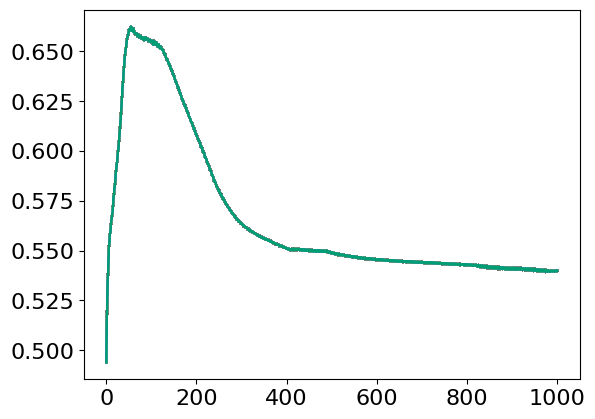

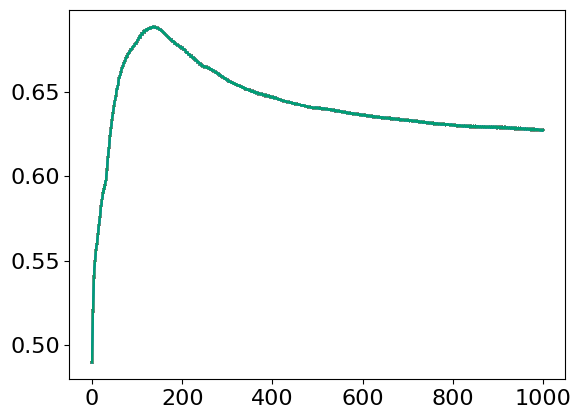

In [15]:

#print(pref)
#print(pref.shape)
#for i in range(N_exc):
#    if np.abs(means[-1,i]) < 0.2: 
#        plt.plot(means[:,i])
#plt.show()
#plt.errorbar(np.arange(200),np.mean(collect_ws, axis =(1,2) ), yerr = np.std(collect_ws, axis =(1,2)))
#plt.show()
for i in range(N_exc):
    plt.errorbar(np.arange(M_IG1.w.shape[1]),np.mean(M_IG1.w, axis =0))#, yerr = np.std(collect_ws[:,:,i], axis =1))
#plt.plot(M_IG.w[:,1])
plt.show()
for i in range(N_exc):
    plt.errorbar(np.arange(M_IG2.w.shape[1]),np.mean(M_IG2.w, axis =0))#, yerr = np.std(collect_ws[:,:,i], axis =1))
#plt.plot(M_IG.w[:,1])
plt.show()

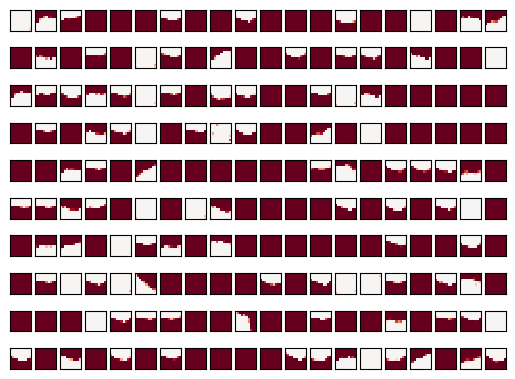

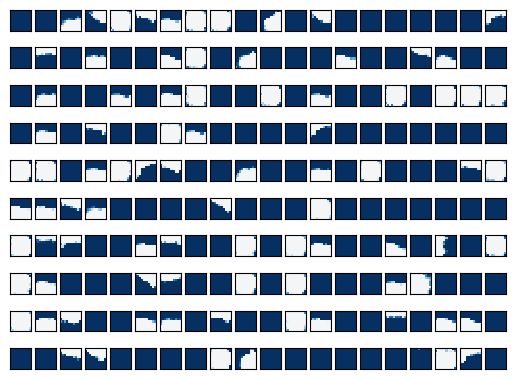

In [16]:
fig, ax = plt.subplots(10,20)
for i in range(20): 
    for j in range(10):
        gp = np.full((N_stim,N_stim), np.nan)
        gp = S_IG1.w[int(i*10 + j)::N_exc].reshape((N_stim,N_stim))
        ax[j,i].imshow(gp, vmin=-1, vmax=1, cmap = 'RdBu_r', interpolation='none')
        ax[j,i].set_xticks(())
        ax[j,i].set_yticks(())
plt.show()

fig, ax = plt.subplots(10,20)
for i in range(20): 
    for j in range(10):
        gp = np.full((N_stim,N_stim), np.nan)
        gp = -1 * S_IG2.w[int(i*10 + j)::N_exc].reshape((N_stim,N_stim))
        ax[j,i].imshow(gp, vmin=-1, vmax=1, cmap = 'RdBu_r', interpolation='none')
        ax[j,i].set_xticks(())
        ax[j,i].set_yticks(())
plt.show()

In [17]:
print(len(true_rfs)) #24

41


In [18]:
####safe the weights of the network in the repo to reload in a simulation quantifying the quality of the representation

#we safe the weights as numpy files of a dictionary for easier loading and reconstruction. 

W_Inp_on = np.full([N_stim*N_stim, N_exc], np.nan)
W_Inp_on[S_IG1.i[:], S_IG1.j[:]] = S_IG1.w

W_Inp_off = np.full([N_stim*N_stim, N_exc], np.nan)
W_Inp_off[S_IG2.i[:], S_IG2.j[:]] = S_IG2.w

W_EE = np.full([N_exc, N_exc], np.nan)
W_EE[S_EE.i[:],  S_EE.j[:]] = S_EE.w[:]

W_IE = np.full([N_exc, N_inh], np.nan)
W_IE[S_IE.i[:],  S_IE.j[:]] = S_IE.w[:]

W_EI = np.full([N_inh, N_exc], np.nan)
W_EI[S_EI.i[:],  S_EI.j[:]] = S_EI.w[:]

W_II = np.full([N_inh, N_inh], np.nan)
W_II[S_II.i[:],  S_II.j[:]] = S_II.w[:]

np.savez('RF_trained_networks/meissner_bernard_proper_randomised.npz', Inp_On = W_Inp_on, Inp_Off = W_Inp_off,
         EE = W_EE, IE = W_IE, EI = W_EI, II = W_II) 